# Dots and Boxes Reinforcement Learning Project

_by Apoorv Pandey_

## Introduction

This project involved:
* Creating a 2-player game-playing program to play [2x2](https://upload.wikimedia.org/wikipedia/commons/thumb/f/fa/Dots-and-boxes.svg/2000px-Dots-and-boxes.svg.png) [Dots and Boxes](https://en.wikipedia.org/wiki/Dots_and_Boxes) using reinforcement learning with a neural network.
    * It made use of the reinforcement learning using neural network code from lecture notes, modified for a 2-player game.
* The AI algorithms used are:
    * Reinforcement learning for 2-player games.
    * Replacing the Q table with a neural network.
* The objective of the project is to train using reinforcement learning in order to determine the most optimal way to play and win a game.

The sources for code in this project are a modified combination of notebooks 15 and 21 from the lecture notes.

## Q Network

Instead of a table implementation for Q, a neural network is used for the reinforcement learning instead.

When using a Q table, the predicted value if the state is not seen/explored previously is 0. However, in a neural network implementation, even if a state is previously unseen/unexplored, a value is generated based on the likeliness of the state to previous states. This should theoretically improve the rate of learning of the reinforcement algorithm, however in practice this is generally not the case, because determining the weights for each layer in the neural network is a challenge.

Basic algorithm of the training is:
* For number of batches, repeat the following:
    * Initialize an empty sample list.
    * Repeat for number of repetitions per batch:
        * Initialize the starting state.
        * Play the game till completion (using `epsilonGreedy` to choose a move).
            * When game is over, determine the appropriate reinforcement and add it to samples.
    * Extract the state + move (13 values) from each sub-list in state as weights, and the reinforcement value and `Qnext` value (values 14 and 15) from each state, whose sum serves as the target.
    * Train the neural network `Qnet` using these data points.

### Functions

The functions implemented for handling the training of the Q network are:
* `epsilonGreedy(Qnet, state, epsilon, validMovesF, turn)`: Returns the next move to be taken by the algorithm; allows for either a random move or a greedy move.
* `trainQnet(nBatches, nRepsPerBatch, hiddenLayers, nIterations, nReplays, epsilon, epsilonDecayFactor, validMovesF, makeMoveF, boxesCreatedF)`: This function trains the neural network which will serve as the Q function; it returns a trained neural network along with the outcomes and samples.
* `drawQnet(network)`: Displays a trained neural network, with the weights at each intermediate layer, how they combine to produce weights for the next layer and so on.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from copy import copy, deepcopy
%matplotlib inline

import neuralnetworks as nn

In [2]:
def epsilonGreedy(Qnet, state, epsilon, validMovesF, turn):
    moves = validMovesF(state)
    if np.random.uniform() < epsilon: # random move
        move = moves[random.sample(range(len(moves)), 1)[0]]
        Q = Qnet.use(np.array(list(state) + [move])) if Qnet.Xmeans is not None else 0
        # one player's randmon move also reduces randomness for other player
        # assumption: other player observes the randomness of an action to learn and reduce randomness
    else: # greedy move
        qs = []
        for m in moves:
            qs.append(Qnet.use(np.array(list(state) + [m])) if Qnet.Xmeans is not None else 0)
        if turn: # if turn is True, play as player 1 (choose max value)
            move = moves[np.argmax(qs)]
            Q = np.max(qs)
        else: # else, play as player 2 (choose min value)
            move = moves[np.argmin(qs)]
            Q = np.min(qs)
            # To have Player 2 play randomly, uncomment the next 2 lines and comment the previous 2 lines
            #move = np.random.choice(moves)
            #Q = Qnet.use(np.array(list(state) + [move])) if Qnet.Xmeans is not None else 0
    return move, Q

In [3]:
def trainQnet(nBatches, nRepsPerBatch, hiddenLayers, nIterations, epsilon, epsilonDecayFactor, validMovesF, makeMoveF, boxesCreatedF):
    outcomes = np.zeros(nBatches*nRepsPerBatch)
    Qnet = nn.NeuralNetwork(13, hiddenLayers, 1)
    repk = -1
    
    for batch in range(nBatches):
        if batch > 0:
            epsilon *= epsilonDecayFactor
            epsilon = max(0.01, epsilon)
        samples = []
        
        for rep in range(nRepsPerBatch):
            repk += 1
            done = False
            turn = True
            
            state = [0]*12
            boxes = [0]*4
            countBoxes = [0]*2
            move, _ = epsilonGreedy(Qnet, state, epsilon, validMovesF, turn)
            
            while not done:
                r = 0
                if turn: # if turn is True, player 1 plays
                    stateNext = makeMoveF(state, move)
                    created, boxes = boxesCreatedF(stateNext, boxes)
                    if not created: # if no boxes created, give turn to other player
                        turn = False
                    else: # else increment boxes created by player 1
                        countBoxes[0] += 1
                    if 0 not in stateNext: # if no more edges remaining, game is over
                        done = True # set termination flag, find reinforcement to add after loop
                        Qnext = 0
                        if countBoxes[0] > countBoxes[1]:
                            r = 1
                        elif countBoxes[0] < countBoxes[1]:
                            r = -1
                        else:
                            r = 0
                        outcomes[repk] = r
                        moveNext = -1
                    else: # else, determine next move and add current sample with reinforcement 0
                        moveNext, Qnext = epsilonGreedy(Qnet, stateNext, epsilon, validMovesF, turn)
                else: # if turn is False, player 2 plays
                    stateNext = makeMoveF(state, move)
                    created, boxes = boxesCreatedF(stateNext, boxes)
                    if not created: # if no boxes created, give turn to other player
                        turn = True
                    else: # else increment boxes created by player 2
                        countBoxes[1] += 1
                    if 0 not in stateNext: # if no more edges remaining, game is over
                        done = True # set termination flag, find reinforcement to add after loop
                        Qnext = 0
                        if countBoxes[0] > countBoxes[1]:
                            r = 1
                        elif countBoxes[0] < countBoxes[1]:
                            r = -1
                        else:
                            r = 0
                        outcomes[repk] = r
                        moveNext = -1
                    else: # else, determine next move and add current sample with reinforcement 0
                        moveNext, Qnext = epsilonGreedy(Qnet, stateNext, epsilon, validMovesF, turn)
                samples.append([*state, move, r, Qnext])
                state = copy(stateNext)
                move = copy(moveNext)
        
        samples = np.array(samples)
        X = samples[:, :13]
        T = samples[:, 13:14]+samples[:, 14:15]
        Qnet.train(X, T, nIterations, verbose = False)
    
    print('DONE')
    return Qnet, outcomes, samples

In [4]:
def drawQnet(network):
    plt.figure(figsize=(10, 10))
    network.draw()

## 2x2 Dots and Boxes

Dots and Boxes is a 2-player game.

Starting with an empty grid of dots, two players take turns adding a single horizontal or vertical line between two unjoined adjacent dots. The player who completes the fourth side of a 1×1 box earns one point and takes another turn. The game ends when no more lines can be placed, with the winner being the player with the most points. The board may be of any size.

In this project, we are using a 2×2 board (a square of 9 dots), which is good for beginners.

In combinatorial game theory, dots and boxes is an impartial game and many positions can be analyzed using Sprague–Grundy theory. However, Dots and Boxes lacks the normal play convention of most impartial games (where the last player to move wins), which complicates the analysis considerably. **\[Reference #1\]**

### Representing the game

Determining how to store and represent the game was a bit tricky, since both the dots and their intermediate edges are valid to the game state. However, representing both dots and edges is not feasible since doing so requires multiple lists, which makes it unviable to use as input parameters to the neural network.

Since the dots are included in every game state, this implementation ignores the dots in the game state. Instead, all the edges in the game are represented as a list (of length 12), with 0 denoting that the edge does not exist, and one denoting otherwise.

The edge ordering for the game is considered as:

**&#183;**&nbsp;&nbsp; 0 &nbsp;&nbsp;**&#183;**&nbsp;&nbsp; 1 &nbsp;&nbsp;**&#183;**  
6 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 7 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; 8  
**&#183;**&nbsp;&nbsp; 2 &nbsp;&nbsp;**&#183;**&nbsp;&nbsp; 3 &nbsp;&nbsp;**&#183;**  
9 &nbsp;&nbsp;&nbsp; 10 &nbsp;&nbsp;&nbsp; 11  
**&#183;**&nbsp;&nbsp; 4 &nbsp;&nbsp;**&#183;**&nbsp;&nbsp; 5 &nbsp;&nbsp;**&#183;**

The index of a value in this list represents the corresponding edge, e.g. if edge 0 exists in a state, then index 0 in the list has value 1, else 0.

### Functions

The functions implemented for the dots and boxes game are:
* `printGame(state)`: Prints the state of the game in a format which is easier to visualize.
* `validMoves(state)`: Returns list of valid moves (moves possible under the aforementioned constraints) from `state`.
* `makeMove(state, move)`: Returns new state after `move` has been applied to `state`.
* `boxCreated(state, boxes):`: Checks if a new box was created and returns an appropriate True/False value.
* `printPrediction(state)`: Prints the values which denote the best/worst steps that can be taken for a state.
* `plotOutcomes(outcomes, maxGames, nGames)`: Displays the average number of wins/losses/draws.

In [5]:
def printGame(state):
    for i in range(3):
        for j in range(3):
            print('\u2022', end = '')
            if i == 0:
                if j == 0:
                    if state[0] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 1:
                    if state[1] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 2:
                    print()
            if i == 1:
                if j == 0:
                    if state[2] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 1:
                    if state[3] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 2:
                    print()
            if i == 2:
                if j == 0:
                    if state[4] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 1:
                    if state[5] == 1:
                        print('---', end = '')
                    else:
                        print('   ', end = '')
                if j == 2:
                    print()
        if i == 0:
            if state[6] == 1:
                if state[7] == 0 and state[8] == 0:
                    print('|')
                else:
                    print('|', end = '')
            if state[7] == 1:
                if state[6] == 0:
                    if state[8] == 0:
                        print('    |')
                    else:
                        print('    |', end = '')
                else:
                    if state[8] == 0:
                        print('   |')
                    else:
                        print('   |', end = '')
            if state[8] == 1:
                if state[7] == 0:
                    if state[6] == 0:
                        print('        |')
                    else:
                        print('       |')
                else:
                    print('   |')
            if state[6] == 0 and state[7] == 0 and state[8] == 0:
                print()
        if i == 1:
            if state[9] == 1:
                if state[10] == 0 and state[11] == 0:
                    print('|')
                else:
                    print('|', end = '')
            if state[10] == 1:
                if state[9] == 0:
                    if state[11] == 0:
                        print('    |')
                    else:
                        print('    |', end = '')
                else:
                    if state[11] == 0:
                        print('   |')
                    else:
                        print('   |', end = '')
            if state[11] == 1:
                if state[10] == 0:
                    if state[9] == 0:
                        print('        |')
                    else:
                        print('       |')
                else:
                    print('   |')
            if state[9] == 0 and state[10] == 0 and state[11] == 0:
                print()

In [6]:
def validMoves(state):
    return list(np.where(np.array(state) == 0)[0])

In [7]:
def makeMove(state, move):
    newState = state.copy()
    newState[move] = 1
    return newState

In [8]:
def boxCreated(state, boxes):
    created = False
    if state[0] == 1 and state[2] == 1 and state[6] == 1 and state[7] == 1:
        if boxes[0] == 0:
            boxes[0] = 1
            created = True
    if state[1] == 1 and state[3] == 1 and state[7] == 1 and state[8] == 1:
        if boxes[1] == 0:
            boxes[1] = 1
            created = True
    if state[2] == 1 and state[4] == 1 and state[9] == 1 and state[10] == 1:
        if boxes[2] == 0:
            boxes[2] = 1
            created = True
    if state[3] == 1 and state[5] == 1 and state[10] == 1 and state[11] == 1:
        if boxes[3] == 0:
            boxes[3] = 1
            created = True
    return created, boxes

In [9]:
def printPrediction(state):
    for i in range(3):
        for j in range(3):
            print('    \u2022    ', end = '')
            if i == 0:
                if j == 0:
                    print(state[0], end = '')
                if j == 1:
                    print(state[1], end = '')
                if j == 2:
                    print()
            if i == 1:
                if j == 0:
                    print(state[2], end = '')
                if j == 1:
                    print(state[3], end = '')
                if j == 2:
                    print()
            if i == 2:
                if j == 0:
                    print(state[4], end = '')
                if j == 1:
                    print(state[5], end = '')
                if j == 2:
                    print()
        if i == 0:
            print(state[6], '    ', state[7], '    ', state[8])
        if i == 1:
            print(state[9], '    ', state[10], '    ', state[11])

In [10]:
def plotOutcomes(outcomes, maxGames, nGames):
    if nGames == 0:
        return
    nBins = 100
    nPer = int(maxGames/nBins)
    outcomeRows = outcomes.reshape((-1, nPer))
    outcomeRows = outcomeRows[:int(nGames/float(nPer))+1, :]
    avgs = np.mean(outcomeRows, axis = 1)
    plt.figure(figsize = (15, 15))
    plt.subplot(2, 1, 1)
    xs = np.linspace(nPer, nGames, len(avgs))
    plt.plot(xs, avgs)
    plt.xlabel('Games')
    plt.ylabel('Mean of Outcomes\n(0=draw, 1=P1 win, -1=P2 win)')
    plt.title('Bins of {:d} Games'.format(nPer))
    plt.subplot(2, 1, 2)
    plt.plot(xs,np.sum(outcomeRows == 1, axis = 1),'g-',label='Wins')
    plt.plot(xs,np.sum(outcomeRows == -1, axis = 1),'r-',label='Losses')
    plt.plot(xs,np.sum(outcomeRows == 0, axis = 1),'b-',label='Draws')
    plt.legend(loc = "center")
    plt.ylabel('Number of Games\nin Bins of {:d}'.format(nPer))

### Testing the functions

In [11]:
startState = [0]*12
printGame(list(startState))

•   •   •

•   •   •

•   •   •


In [12]:
validMoves(startState)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

In [13]:
makeMove(startState, 1)

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [14]:
exampleState = makeMove(startState, 3)
print(exampleState)
print()
printGame(makeMove(startState, 3))

[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]

•   •   •

•   •---•

•   •   •


In [15]:
state = [1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0]
boxes = [1, 0, 0, 0]
printGame(state)
created, boxes = boxCreated(state, boxes)
print()
print(created)
print()
print(boxes)

•---•---•
|   |   |
•---•   •

•   •   •

False

[1, 0, 0, 0]


Value returned is false, because while box does exist in the state, the value of at the box's corresponding index is already 1.

In [16]:
state = [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0]
boxes = [1, 0, 0, 0]
printGame(state)
created, boxes = boxCreated(state, boxes)
print()
print(created)
print()
print(boxes)

•---•---•
|   |   |
•---•---•

•   •   •

True

[1, 1, 0, 0]


However, if we create another box while have the same box list, the value returned is true, since the next box also exists, but it's corresponding index value in the list is 0.

### Solving the problem

Now that the functions have been defined and tested, let's try to solve the problem. This will require multiple experiments to determine the change in learning based on variation of the hidden layer structure, and other factors such as the epsilon decay rate, etcetera.

#### Parameter experiment \#1

In [17]:
hiddenLayers = [10] # 1 hidden layer, with 10 units
nIterations = 50
epsilon = 1
epsilonDecayFactor = 0.95

In [18]:
Qnet1, outcomes1, samples1 = trainQnet(20, 1000, hiddenLayers, nIterations,
                                    epsilon, epsilonDecayFactor, validMoves, makeMove, boxCreated)

DONE


In [19]:
startState = [0]*12
Q1s = [Qnet1.use(startState + [m]) for m in range(12)]
printPrediction(Q1s)

    •    [[0.12256059]]    •    [[0.1215418]]    •    
[[0.05244696]]      [[0.07073275]]      [[0.08109017]]
    •    [[0.09944577]]    •    [[0.02159369]]    •    
[[0.08630132]]      [[0.08868445]]      [[0.08968763]]
    •    [[0.00193287]]    •    [[0.02575892]]    •    


**\[Observation #1\]**

Let's plot the outcomes when using these parameters.

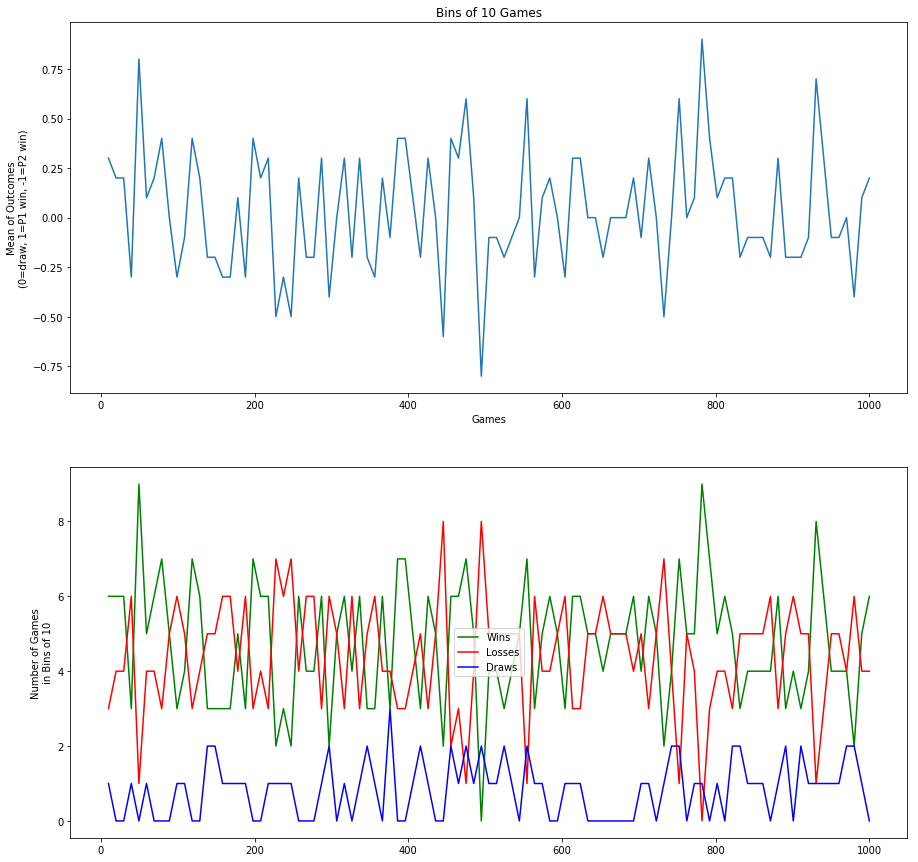

In [20]:
plotOutcomes(outcomes1, 1000, 1000)

**\[Observation #2\]**

Also, let's have a look at the trained neural network.

8.649500536973125 1.0784414941440449e-05 566.8934240362812


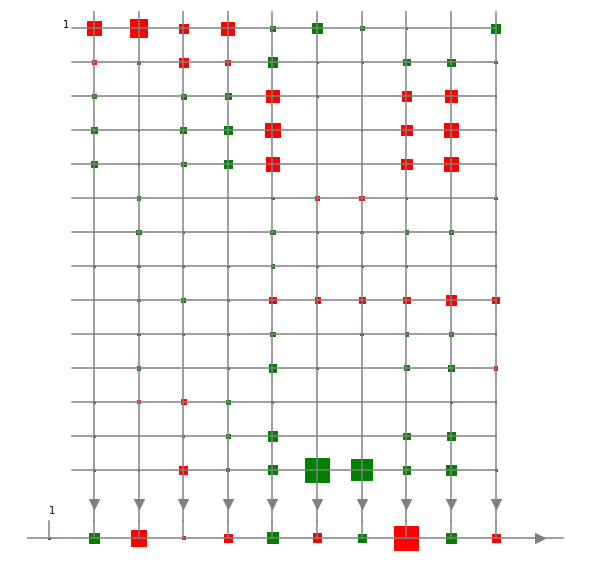

In [21]:
drawQnet(Qnet1)

#### Parameter experiment \#2

In [22]:
hiddenLayers = [5, 5] # 2 hidden layers, with 5 units each
nIterations = 25
epsilon = 1
epsilonDecayFactor = 0.925

In [23]:
Qnet2, outcomes2, samples2 = trainQnet(20, 1000, hiddenLayers, nIterations,
                                    epsilon, epsilonDecayFactor, validMoves, makeMove, boxCreated)

DONE


In [24]:
startState = [0]*12
Q2s = [Qnet2.use(startState + [m]) for m in range(12)]
printPrediction(Q2s)

    •    [[0.24515561]]    •    [[0.22552131]]    •    
[[0.15253328]]      [[0.15866684]]      [[0.16800781]]
    •    [[0.20362863]]    •    [[0.18279283]]    •    
[[0.17119055]]      [[0.17030893]]      [[0.16859742]]
    •    [[0.16649943]]    •    [[0.15596852]]    •    


**\[Observation #1\]**

Let's plot the outcomes when using these parameters.

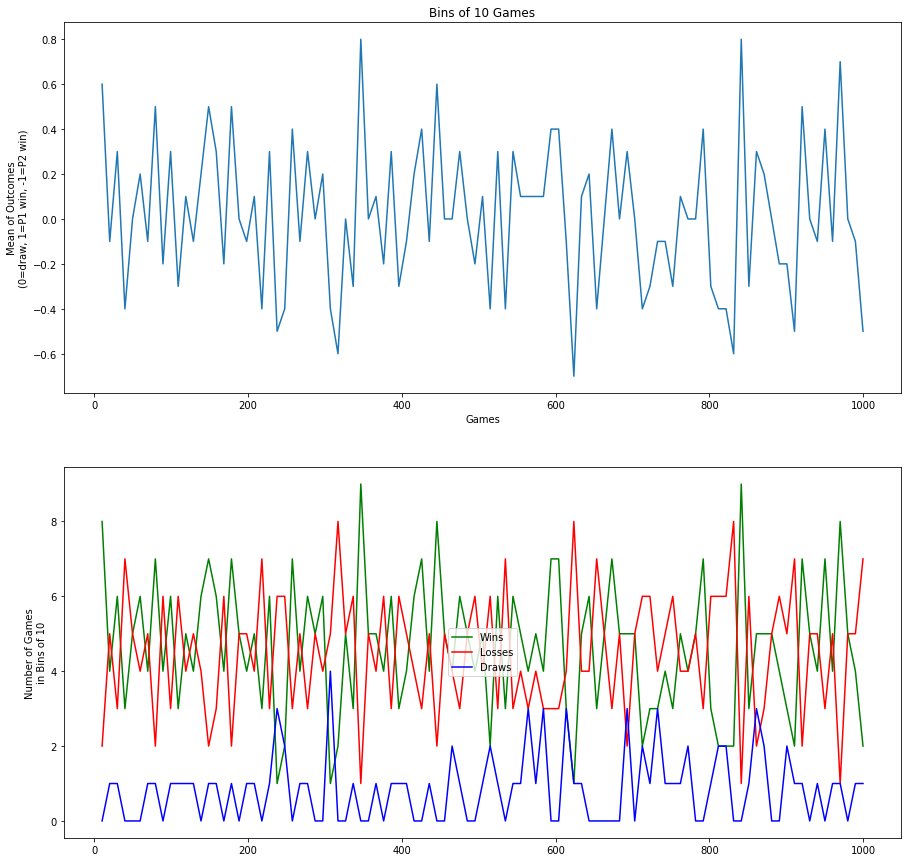

In [25]:
plotOutcomes(outcomes2, 1000, 1000)

**\[Observation #2\]**

Also, let's have a look at the trained neural network.

6.665910628517825 0.006482651602878592 400.0
7.107378599904764 80.71410429944174 400.0


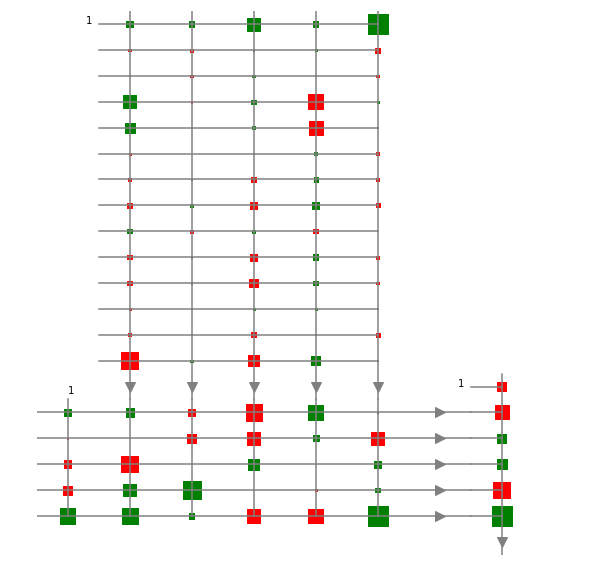

In [26]:
drawQnet(Qnet2)

#### Parameter experiment \#3

In [27]:
hiddenLayers = [20, 20, 20] # 3 hidden layers, with 20 units each
nIterations = 10
epsilon = 1
epsilonDecayFactor = 0.99

In [28]:
Qnet3, outcomes3, samples3 = trainQnet(20, 1000, hiddenLayers, nIterations,
                                    epsilon, epsilonDecayFactor, validMoves, makeMove, boxCreated)

DONE


In [29]:
startState = [0]*12
Q3s = [Qnet3.use(startState + [m]) for m in range(12)]
printPrediction(Q3s)

    •    [[0.04628916]]    •    [[0.04605832]]    •    
[[0.03528406]]      [[0.0320225]]      [[0.02838812]]
    •    [[0.04448753]]    •    [[0.04257146]]    •    
[[0.02451593]]      [[0.02057576]]      [[0.01674793]]
    •    [[0.04048912]]    •    [[0.03810018]]    •    


**\[Observation #1\]**

Let's plot the outcomes when using these parameters.

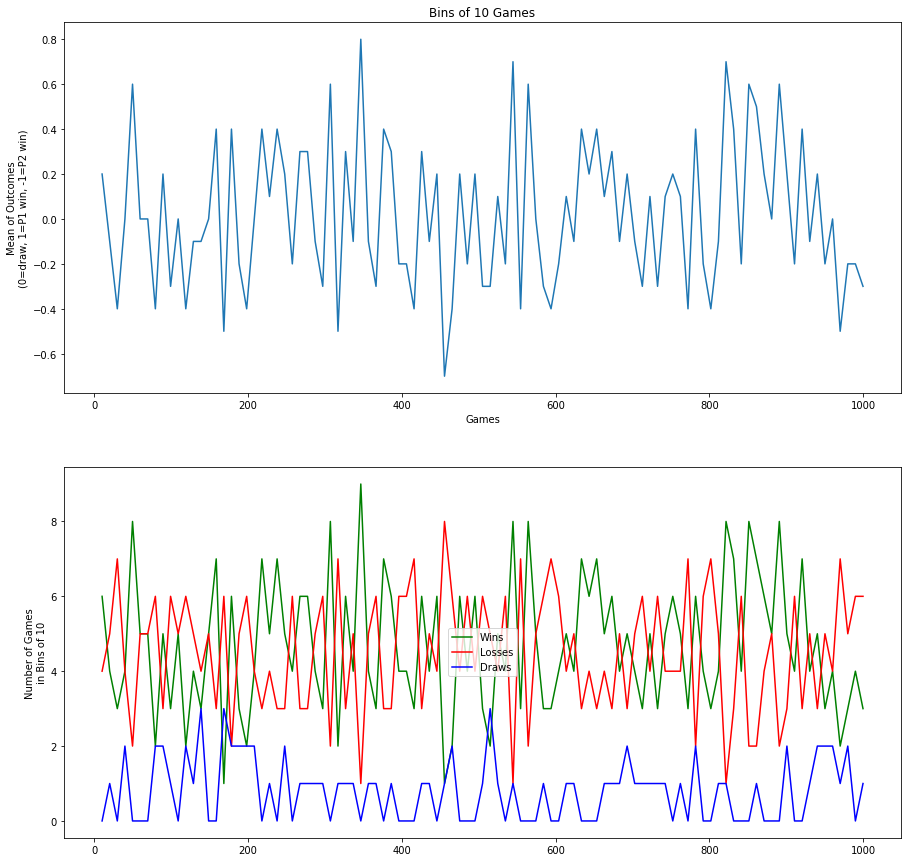

In [30]:
plotOutcomes(outcomes3, 1000, 1000)

**\[Observation #2\]**

Also, let's have a look at the trained neural network.

4.6818255122455055 3.0304792010591618e-05 37.180249851279
7.825068368224988 5.57612775565454e-05 37.180249851279


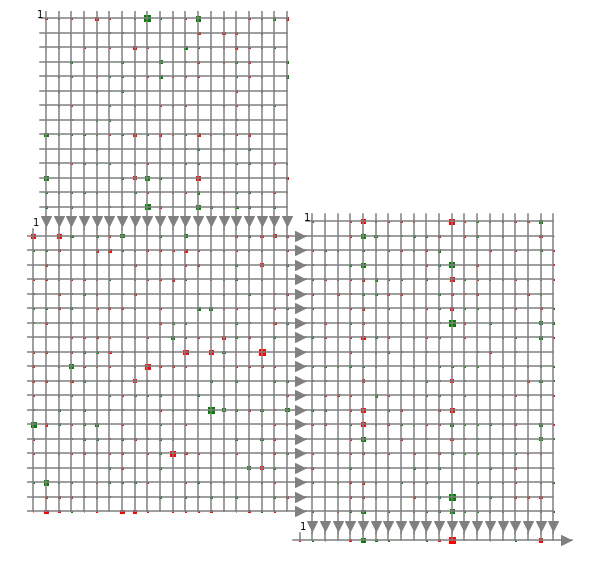

In [31]:
drawQnet(Qnet3)

### Exploring the Qnet(s)

Let's explore all the trained neural networks thus far for other states, to see how they behave/perform.

#### State experiment \#1

In [32]:
state = [1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0]
printGame(state)
moves = validMoves(state)

•---•   •
|
•---•   •

•   •   •


Let's try the above state, and try to print the move predicted by each of the trained neural networks.

In [33]:
Qs = [Qnet1.use(state + [m]) for m in moves]
print('Best move for player 1 according to first neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to first neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network
•---•   •
|   |
•---•   •

•   •   •
Best move for player 2 according to first neural network
•---•   •
|
•---•---•

•   •   •


In [34]:
Qs = [Qnet2.use(state + [m]) for m in moves]
print('Best move for player 1 according to second neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to second neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network
•---•---•
|
•---•   •

•   •   •
Best move for player 2 according to second neural network
•---•   •
|
•---•   •
|
•   •   •


In [35]:
Qs = [Qnet3.use(state + [m]) for m in moves]
print('Best move for player 1 according to third neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to third neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network
•---•   •
|   |
•---•   •

•   •   •
Best move for player 2 according to third neural network
•---•---•
|
•---•   •

•   •   •


**\[Observation #3\]**

#### State experiment \#2

In [36]:
state = [1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0]
printGame(state)
moves = validMoves(state)

•---•---•
|       |
•---•---•

•   •   •


Let's try the above state, and try to print the move predicted by each of the trained neural networks.

In [37]:
Qs = [Qnet1.use(state + [m]) for m in moves]
print('Best move for player 1 according to first neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to first neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network
•---•---•
|       |
•---•---•
|
•   •   •
Best move for player 2 according to first neural network
•---•---•
|       |
•---•---•

•---•   •


In [38]:
Qs = [Qnet2.use(state + [m]) for m in moves]
print('Best move for player 1 according to second neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to second neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network
•---•---•
|       |
•---•---•

•---•   •
Best move for player 2 according to second neural network
•---•---•
|       |
•---•---•
        |
•   •   •


In [39]:
Qs = [Qnet3.use(state + [m]) for m in moves]
print('Best move for player 1 according to third neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to third neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network
•---•---•
|       |
•---•---•
        |
•   •   •
Best move for player 2 according to third neural network
•---•---•
|       |
•---•---•

•---•   •


**\[Observation #3\]**

#### State experiment \#3

In [40]:
state = [1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1]
printGame(state)
moves = validMoves(state)

•---•---•
|       |
•---•   •
|       |
•---•---•


Let's try the above state, and try to print the move predicted by each of the trained neural networks.

In [41]:
Qs = [Qnet1.use(state + [m]) for m in moves]
print('Best move for player 1 according to first neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to first neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to first neural network
•---•---•
|       |
•---•   •
|   |   |
•---•---•
Best move for player 2 according to first neural network
•---•---•
|   |   |
•---•   •
|       |
•---•---•


In [42]:
Qs = [Qnet2.use(state + [m]) for m in moves]
print('Best move for player 1 according to second neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to second neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to second neural network
•---•---•
|       |
•---•   •
|   |   |
•---•---•
Best move for player 2 according to second neural network
•---•---•
|       |
•---•---•
|       |
•---•---•


In [43]:
Qs = [Qnet3.use(state + [m]) for m in moves]
print('Best move for player 1 according to third neural network')
printGame(makeMove(state, moves[(np.argmax(np.array(Qs)))]))
print('Best move for player 2 according to third neural network')
printGame(makeMove(state, moves[(np.argmin(np.array(Qs)))]))

Best move for player 1 according to third neural network
•---•---•
|       |
•---•   •
|   |   |
•---•---•
Best move for player 2 according to third neural network
•---•---•
|   |   |
•---•   •
|       |
•---•---•


**\[Observation #3\]**

## Observations

1. The values returned by the neural network are extremely sparse. This is because:
    * The reinforcements during the training are extremely sparse, with the only reinforcements other than 0 being 1 and -1, and that too only when player 1 wins or loses. Hence, the intermediate steps have extremely low values.
    * The game of dots and boxes is designed so that both players have equal probability/likelihood of winning. Hence, the number of positive reinforcements for a state are almost the same as the number of negative reinforcements, making the overall values much lower.
2. The number of wins and losses for each player fluctuate quite rapidly, not skewing in favor of any particular even after many repetitions and lot of learning. This is because:
    * The game of dots and boxes is designed so that both players have equal probability/likelihood of winning.
    * Both players are playing optimally, hence they are both learning at the same pace with each outcome, hence the overall performance between the two is quite balanced.
3. Since this is a reinforcement learning program, with both players playing optimally, the local greedy move might not be the best move overall, as it might not lead to an overall win.
    * Hence in state experiment \#1 and \#2, the seemingly best move is not selected, likely because the reinforcements/past experience show that the player would lose overall.
    * On the other hand, in state experiment \#3, generally the optimal move is chosen instead.

## Results

The values for each edge/available move at the starting state are displayed. Higher values denote moves which have a higher likelihood of player 1 winning, and vice versa.

The average outcomes for the games are also collected and plotted to determine the performance of the program over time. Unlike the expected outcome of reinforcement learning, where the number of wins gradually continues to improve with experience, in this scenario, the number of wins and losses is fairly evenly balanced due to both players playing optimally.

After that, the Qnets are explored in more detail, to determine which best optimal move they predict for random states. In certain cases, the seemingly obvious move is not chosen, likely due to past experience indicating that while it might _seem_ like a good move, it resulted in a loss overall.

## References

1. Berlekamp, Elwyn R.; Conway, John H.; Guy, Richard K. (1982), "Chapter 16: Dots-and-Boxes", _Winning Ways for your Mathematical Plays, Volume 2: Games in Particular_, Academic Press, pp. 507–550.